# Performance profiling of OpenCL 

In the scope of the upgrade of ID29 for serial crystallography.

We will use some data of serial crystallography of ID13

In [1]:
%matplotlib inline

In [2]:
import os
import numpy, pyFAI, fabio, h5py
eiger = pyFAI.detector_factory("Eiger4M")
os.environ["HDF5_PLUGIN_PATH"]="/usr/lib/x86_64-linux-gnu/hdf5/plugins"

/mntdirect/_scisoft/users/jupyter/jupy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
datafile = "/scratch/kieffer/ID29_Serial/lys8_16_data_000101.h5"
h5 = h5py.File(datafile)
dataset = h5["entry/data/data"]
print(dataset.shape)

(1000, 2167, 2070)


In [4]:
maxi = dataset[...].max(axis=0)
msk = (maxi>60000).astype("int8")
eiger.mask = msk

In [5]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

In [6]:
ai = AzimuthalIntegrator(detector=eiger)
ai.setFit2D(100, 1162, 1263)

Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
SampleDetDist= 1.000000e-01m	PONI= 9.472500e-02, 8.715000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 100.000mm	Center: x=1162.000, y=1263.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

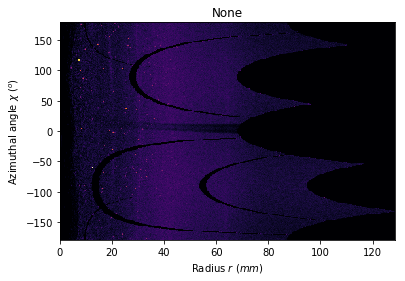

In [7]:
from pyFAI.gui import jupyter
jupyter.plot2d(ai.integrate2d(dataset[110], 512, 256, unit="r_mm", method="ocl_csr_0,0"))

In [8]:
engine = ai.engines["ocl_csr_integr"].engine
engine.set_profiling(True)

In [9]:
%%time
for img in dataset:
    engine.integrate(img)

CPU times: user 10.9 s, sys: 3 s, total: 13.9 s
Wall time: 13.9 s


In [10]:
print("\n".join(engine.log_profile()))


Profiling info for OpenCL OCL_CSR_Integrator
                               copy raw H->D image:	2.237ms
                                 cast u16_to_float:	0.085ms
                                        memset_out:	0.010ms
                                       corrections:	0.233ms
                                         integrate:	0.740ms
                                  copy D->H merged:	0.041ms
                                copy D->H sum_data:	0.048ms
                               copy D->H sum_count:	0.042ms
                               copy raw H->D image:	2.184ms
                                 cast u16_to_float:	0.085ms
                                        memset_out:	0.010ms
                                       corrections:	0.233ms
                                         integrate:	0.741ms
                                  copy D->H merged:	0.042ms
                                copy D->H sum_data:	0.047ms
                               copy D->H sum_count:	0.

In [10]:
engine.ctx

<pyopencl.Context at 0x5636bfe9c270 on <pyopencl.Device 'Quadro P6000' on 'NVIDIA CUDA' at 0x5636c0407490>>

In [11]:
pyFAI.opencl.ocl

OpenCL devices:
[0] NVIDIA CUDA: (0,0) Quadro P6000, (0,1) GeForce GTX TITAN X
[1] Intel(R) OpenCL: (1,0) Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
[2] AMD Accelerated Parallel Processing: (2,0) Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz

In [12]:
summed_timimgs = {}
for ed in engine.events:
    t = 1e-6 * (ed.event.profile.end - ed.event.profile.start) #millisocond
    if ed.name in summed_timimgs:
        summed_timimgs[ed.name] += t
    else:
        summed_timimgs[ed.name] = t


In [13]:
for k,v in summed_timimgs.items():
    print("%50s %.3f"%(k, v))

                                 cast u16_to_float 86.791
                               copy D->H sum_count 51.477
                                         integrate 743.282
                                        memset_out 9.263
                                copy D->H sum_data 40.796
                                       corrections 234.778
                                  copy D->H merged 40.557
                               copy raw H->D image 1039.786


In [9]:
pyFAI.opencl.ocl

OpenCL devices:
[0] NVIDIA CUDA: (0,0) Quadro P6000, (0,1) GeForce GTX TITAN X
[1] Intel(R) OpenCL: (1,0) Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz
[2] AMD Accelerated Parallel Processing: (2,0) Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz